In [1]:
import preprocessing as pp
import sampling
import random
import torch
from models import graphClassifier, nodeClassifier
from torch_geometric.loader import DataLoader
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:

nodesFileNerve =  "~/Documents/Intestine/nerve-mask/nodes_nerve_bs2.csv"
edgesFileNerve = "~/Documents/Intestine/nerve-mask/edges_nerve_bs2.csv"

nodesFileLymph =  "~/Documents/Intestine/lymph-mask/nodes_lymph_bs2.csv"
edgesFileLymph = "~/Documents/Intestine/lymph-mask/edges_lymph_bs2.csv"



nodes_n = pd.read_csv(nodesFileNerve, sep = ";", index_col= "id")
edges_n = pd.read_csv(edgesFileNerve, sep = ";", index_col= "id")
nodes_l = pd.read_csv(nodesFileLymph, sep = ";", index_col= "id")
edges_l = pd.read_csv(edgesFileLymph, sep = ";", index_col= "id")


# scaling with the factors provided by luciano
nodes_l = pp.scalePosition(nodes_l, (1.65,1.65,6))
nodes_n = pp.scalePosition(nodes_n, (1.65,1.65,6))

# create the graphs for both networks
G_nerve = pp.createGraph(nodes_n, edges_n, index_addon ="n")
G_lymph = pp.createGraph(nodes_l, edges_l, index_addon ="l")

# get short description of graph
pp.graphSummary(G_nerve)
pp.graphSummary(G_lymph)

# get rid of self-loops, multi edges and isolated nodes
G_nerve_einf = pp.convertToEinfach(G_nerve)
G_lymph_einf = pp.convertToEinfach(G_lymph)

# enrich the attributes of the nodes with information from the incident edges
pp.enrichNodeAttributes(G_lymph_einf)
pp.enrichNodeAttributes(G_nerve_einf)


***************
Number of Nodes: 4317
Number of Edges: 6634
Number of Connected Components: 22
Number of Self Loops: 528
Number of Isolated Nodes: 0
Average Node Degree: 3.073430623117906
***************
***************
Number of Nodes: 3036
Number of Edges: 3864
Number of Connected Components: 89
Number of Self Loops: 25
Number of Isolated Nodes: 1
Average Node Degree: 2.5454545454545454
***************


# Graph Classification using Subsets of Lymph and Nerve Network for Training and Testing

In [3]:

# create random samples 
randomSampleLymphNx, randomSampleLymph = sampling.randomGeomSubgraphs(G_lymph_einf, label = 1,starts = 100, node_sample_size = 100,  mode = "rnn")
randomSampleNerveNx, randomSampleNerve = sampling.randomGeomSubgraphs(G_nerve_einf, label = 0,starts = 100, node_sample_size = 100,  mode = "rnn")

# combine the graphs to a random set
allGraphs = randomSampleLymph + randomSampleNerve
random.shuffle(allGraphs)

# split into training and test set
breaker = int(len(allGraphs)*0.8)
train_dataset = allGraphs[:breaker]
test_dataset = allGraphs[breaker:]

Creating subgraphs using random node neighbor selection.: 100%|██████████| 100/100 [00:00<00:00, 518.00it/s]
Creating subgraphs using random node neighbor selection.: 100%|██████████| 100/100 [00:00<00:00, 247.23it/s]


In [4]:
# selection of the features to use
feat_slice = [1,3,7,8]

# create the model
model = graphClassifier.GCN_GC(hidden_channels=32, in_features = len(feat_slice), classes = 2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# create brach data loaders for training and test set
train_loader = DataLoader(train_dataset, batch_size= 64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)



def train_GC():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x[:,feat_slice], data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test_GC(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x[:,feat_slice], data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.



for epoch in range(1, 11):
    train_GC()
    train_acc = test_GC(train_loader)
    test_acc = test_GC(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')



# good features: 1,3 - both features that have to do with length                performance is best if just these 2 features are used
# good features: 7,8 - both features that have to do with distance
# medium features: 6 - num Voxels
# medium features: 4 - curveness
# trash feature: 0,2 - both features that have to do with minRadiusAvg
# trash feature: 5 - avgRadiusStd



# 16 hidden layers seems favorable compared to 64 or 8

# slice = [1,3,7,8] leads to very good results
# slice = [1,3] results are equal to 1,3,7,8 ... maybe better

Epoch: 001, Train Acc: 0.5034, Test Acc: 0.4054
Epoch: 002, Train Acc: 0.5103, Test Acc: 0.4054
Epoch: 003, Train Acc: 0.6828, Test Acc: 0.5405
Epoch: 004, Train Acc: 0.8759, Test Acc: 0.7568
Epoch: 005, Train Acc: 0.9310, Test Acc: 0.9189
Epoch: 006, Train Acc: 0.9655, Test Acc: 0.8649
Epoch: 007, Train Acc: 0.9655, Test Acc: 0.8378
Epoch: 008, Train Acc: 0.8897, Test Acc: 0.8919
Epoch: 009, Train Acc: 0.9310, Test Acc: 0.8108
Epoch: 010, Train Acc: 0.9034, Test Acc: 0.9189


# Node Classification using a contracted graph by spatial proximity to differentiate 3 node types (nerve, lymph, connected)

In [5]:
#rename the nodes to have unqiue identifiers for different types
# giving nodes from different files unique names
edges_n, nodes_n = pp.relable_edges_nodes(edges_n, nodes_n, "n")
edges_l, nodes_l = pp.relable_edges_nodes(edges_l, nodes_l, "l")


In [6]:
from scipy.spatial import KDTree
from scipy.sparse import csr_matrix
from scipy.sparse import dok_array
from scipy.sparse.csgraph import connected_components

# create an adjacency matrix for nodes from two node sets that are closer than a given distance
adjMcsr = pp.distance_based_adjacency(nodes_n, nodes_l, th = 0.03)

# find the connected components in the adjacency matrix (nodes that will be merged)
num, labels = connected_components(csgraph=adjMcsr, directed = False)

#create a dict where each new node contains all the nodes that will be merged into it
con_comp = pp.connected_components_dict(labels)

#take only the connected components that contain > 1 element, otherwise no merge is necessary 
rel_comp = pp.relevant_connected_components(con_comp, nodes_n.shape[0], ("n","l"))



reverse_dict= {}
for k, v in rel_comp.items():
    for val in v:
        reverse_dict[val] = k



In [7]:
merged_nodes = pd.concat([nodes_l.loc[:,["pos_x", "pos_y", "pos_z"]], nodes_n.loc[:,["pos_x", "pos_y", "pos_z"]]])
new_nodes = pd.DataFrame(columns=merged_nodes.columns )

# replace the contracted node with new nodes
# the position of the new node is an average of all the previous nodes
for k, valList in rel_comp.items():
    new_nodes.loc[k] = merged_nodes.loc[valList].mean()
    merged_nodes.drop(valList, inplace = True)


# concat the all nodes and the new nodes
merged_nodes = pd.concat([merged_nodes, new_nodes])

# createa a combined edge file
merged_edges = pd.concat([edges_l, edges_n], ignore_index = True)

print(merged_edges.shape[0])
drop_count = 0
# change the names of the edges to the new names
for idxE, edge in merged_edges.iterrows():
    if edge["node1id"] in reverse_dict.keys():
        merged_edges.loc[idxE,"node1id"] = reverse_dict[edge["node1id"]]
    if edge["node2id"] in reverse_dict.keys():
        merged_edges.loc[idxE,"node2id"] = reverse_dict[edge["node2id"]]
    if edge["hasNodeAtSampleBorder"]:
        merged_edges.drop([idxE], inplace = True)
        drop_count +=1

print(drop_count)
print(merged_edges.shape[0])

# create a new graph based on the old information
G_contract = pp.createGraph(merged_nodes, merged_edges)
G_contract_einf = pp.convertToEinfach(G_contract, self_loops = False, isolates = False)
pp.enrichNodeAttributes(G_contract_einf)

10498
207
10291


In [8]:
# create the ground truth for the node class
all_nodes = list(G_contract_einf.nodes)
nerve_class = np.array([elem[-1] == "n" for elem in all_nodes])*0
lymph_class = np.array([elem[-1] == "l" for elem in all_nodes])*1
combined_class = np.array([elem[-1] == "c" for elem in all_nodes])*2
class_assign = nerve_class+lymph_class+combined_class


# create the training and testing masks
train_mask = np.random.choice(np.arange(0, len(class_assign)), size= int(len(class_assign)*0.8), replace = False)
test_mask = np.delete(np.arange(0, len(class_assign)), train_mask)

# convert to torch tensor objects
train_mask= torch.tensor(train_mask)
test_mask= torch.tensor(test_mask)

np.random.seed(1234567)
unique, counts = np.unique(class_assign[train_mask], return_counts=True)
print("Train-Mask Class Distribution: ")
print(unique)
print(counts)

print("Test-Mask Class Distribution: ")
unique, counts = np.unique(class_assign[test_mask], return_counts=True)
print(unique)
print(counts)


# convert the graph to a networkx graph

from torch_geometric.utils.convert import from_networkx
networkXG = from_networkx(G_contract_einf)
networkXG.y = torch.tensor(class_assign)


Train-Mask Class Distribution: 
[0 1 2]
[3163 2133  161]
Test-Mask Class Distribution: 
[0 1 2]
[792 544  29]


In [9]:
num_feat = networkXG.x.shape[1]
num_class = len(np.unique(networkXG.y))
netGCN = nodeClassifier.GCN_NC
netSAGE = nodeClassifier.SAGE_NC
netWC = nodeClassifier.WC_NC

optimizer = torch.optim.Adam
criterion = torch.nn.CrossEntropyLoss
modelGCN = nodeClassifier.nodeClassifier(netGCN, hidden_channels=32, features = np.arange(num_feat),classes = num_class, optimizer = optimizer, lossFunc = criterion)
modelSAGE = nodeClassifier.nodeClassifier(netSAGE, hidden_channels=32, features = np.arange(num_feat),classes = num_class, optimizer = optimizer, lossFunc = criterion)
modelWC = nodeClassifier.nodeClassifier(netWC, hidden_channels=32, features = np.arange(num_feat),classes = num_class, optimizer = optimizer, lossFunc = criterion)

models = [modelGCN, modelSAGE, modelWC]
models = [modelGCN]


epochs = 100
loss_l = np.zeros((epochs, len(models)))
acc_l = np.zeros((epochs, len(models)))
for epoch in range(1, epochs +1):
      for i, model in enumerate(models):
            loss = model.train(networkXG, train_mask)
            loss_l[epoch-1, i] = loss.detach().numpy().copy()
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
            test_acc = model.test(networkXG, test_mask)
            acc_l[epoch-1, i] = test_acc

for model in models:
      test_acc = model.test(networkXG, test_mask)
      print(f'Test Accuracy: {test_acc:.4f}')

#100 iter:
#13: 58.75%       trash
#12: 58.75%       trash
#11: 62.03%
#10: 69.11 %
#9:  58.75 %      trash
#8:  78.69 %
#7:  78.40 %
#6:  81.08 %
#5:  58.75 %      trash
#4:  68.69 %
#3:  79.97 %
#2:  58.75 %      trash
#1:  79.97 %
#0:  58.75 %      trash

#all:        82.56 %
#no trash:   81.11 %
# >75:       81.96 %
#[1,6,8,10]: 80.77 %

#500 iter:
#all:        82.56 %


Epoch: 001, Loss: 1.5062
Epoch: 002, Loss: 1.4982
Epoch: 003, Loss: 1.2434
Epoch: 004, Loss: 1.2089
Epoch: 005, Loss: 1.1586
Epoch: 006, Loss: 1.0288
Epoch: 007, Loss: 1.0189
Epoch: 008, Loss: 1.0001
Epoch: 009, Loss: 0.9375
Epoch: 010, Loss: 0.8922
Epoch: 011, Loss: 0.8903
Epoch: 012, Loss: 0.8849
Epoch: 013, Loss: 0.8410
Epoch: 014, Loss: 0.8125
Epoch: 015, Loss: 0.8151
Epoch: 016, Loss: 0.8108
Epoch: 017, Loss: 0.7956
Epoch: 018, Loss: 0.7838
Epoch: 019, Loss: 0.7809
Epoch: 020, Loss: 0.7513
Epoch: 021, Loss: 0.7443
Epoch: 022, Loss: 0.7341
Epoch: 023, Loss: 0.7249
Epoch: 024, Loss: 0.7061
Epoch: 025, Loss: 0.6955
Epoch: 026, Loss: 0.6859
Epoch: 027, Loss: 0.6770
Epoch: 028, Loss: 0.6715
Epoch: 029, Loss: 0.6592
Epoch: 030, Loss: 0.6528
Epoch: 031, Loss: 0.6442
Epoch: 032, Loss: 0.6372
Epoch: 033, Loss: 0.6250
Epoch: 034, Loss: 0.6171
Epoch: 035, Loss: 0.6150
Epoch: 036, Loss: 0.6149
Epoch: 037, Loss: 0.6068
Epoch: 038, Loss: 0.5990
Epoch: 039, Loss: 0.5967
Epoch: 040, Loss: 0.5891


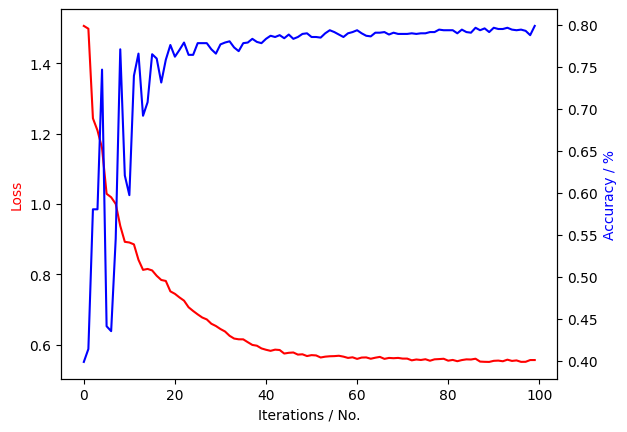

In [10]:
for i in range(len(models)):
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(loss_l[:,i], color = "red")
    ax2.plot(acc_l[:,i], color = "blue")

    ax1.set_xlabel('Iterations / No.')
    ax1.set_ylabel('Loss', color='r')
    ax2.set_ylabel('Accuracy / %', color='b')



#### Try node classification for the dual graph.

In [11]:
import networkx as nx
L = nx.line_graph(G_contract_einf)



dual_node_features ={}

for idxE, edge in merged_edges.iterrows():
    try:
        L[(edge["node1id"],edge["node2id"])]
        dual_node_features[(edge["node1id"],edge["node2id"])] = np.array(edge[2:], dtype = float)
    except KeyError:
        try:
            L[(edge["node2id"],edge["node1id"])]
            dual_node_features[(edge["node2id"],edge["node1id"])] = np.array(edge[2:], dtype = float)
        except KeyError:
            continue


nx.set_node_attributes(L, dual_node_features, name="x")


networkDualXG = from_networkx(L)

node_lab = {}
class_label = -1
class_label_list = []
for k, node in L.nodes.items():
    hashval = hash(k[0][-1]) + hash(k[0][-1])
    try:
        class_label_list.append(node_lab[hashval])
    except KeyError:
        class_label = class_label +1
        node_lab[hashval] = class_label
        class_label_list.append(node_lab[hashval])


networkDualXG.y = torch.tensor(class_label_list)


#networkDualXG.edge_index

/home/laurin/.local/lib/python3.8/site-packages/torch_geometric/utils/convert.py:192: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:204.)
  data[key] = torch.tensor(value)


In [12]:
# create the training and testing masks
train_mask_dual = np.random.choice(np.arange(0, len(class_label_list)), size= int(len(class_label_list)*0.8), replace = False)
test_mask_dual = np.delete(np.arange(0, len(class_label_list)), train_mask_dual)

# convert to torch tensor objects
train_mask_dual= torch.tensor(train_mask_dual)
test_mask_dual= torch.tensor(test_mask_dual)


num_feat_dual = networkDualXG.x.shape[1]
num_class_dual = len(np.unique(networkDualXG.y))


In [13]:
optimizer = torch.optim.Adam
criterion = torch.nn.CrossEntropyLoss
modelGCN = nodeClassifier.nodeClassifier(netGCN, hidden_channels=64, features = np.arange(num_feat_dual),classes = num_class_dual, optimizer = optimizer, lossFunc = criterion)
modelSAGE = nodeClassifier.nodeClassifier(netSAGE, hidden_channels=32, features = np.arange(num_feat_dual),classes = num_class_dual, optimizer = optimizer, lossFunc = criterion)
modelWC = nodeClassifier.nodeClassifier(netWC, hidden_channels=32, features = np.arange(num_feat_dual),classes = num_class_dual, optimizer = optimizer, lossFunc = criterion)


dualModel = modelGCN


epochs = 200
loss_l = np.zeros((epochs, 1))
acc_l = np.zeros((epochs, 1))
for epoch in range(1, epochs +1):
      loss = dualModel.train(networkDualXG, train_mask_dual)
      loss_l[epoch-1, i] = loss.detach().numpy().copy()
      print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
      test_acc = dualModel.test(networkDualXG, test_mask_dual)
      acc_l[epoch-1, i] = test_acc


test_acc = dualModel.test(networkDualXG, test_mask_dual)
print(f'Test Accuracy: {test_acc:.4f}')

Epoch: 001, Loss: 2.0527
Epoch: 002, Loss: 0.8400
Epoch: 003, Loss: 0.6891
Epoch: 004, Loss: 0.6452
Epoch: 005, Loss: 0.5894
Epoch: 006, Loss: 0.5728
Epoch: 007, Loss: 0.5597
Epoch: 008, Loss: 0.5709
Epoch: 009, Loss: 0.5737
Epoch: 010, Loss: 0.5715
Epoch: 011, Loss: 0.5647
Epoch: 012, Loss: 0.5649
Epoch: 013, Loss: 0.5542
Epoch: 014, Loss: 0.5595
Epoch: 015, Loss: 0.5533
Epoch: 016, Loss: 0.5448
Epoch: 017, Loss: 0.5470
Epoch: 018, Loss: 0.5392
Epoch: 019, Loss: 0.5314
Epoch: 020, Loss: 0.5332
Epoch: 021, Loss: 0.5333
Epoch: 022, Loss: 0.5345
Epoch: 023, Loss: 0.5297
Epoch: 024, Loss: 0.5266
Epoch: 025, Loss: 0.5244
Epoch: 026, Loss: 0.5220
Epoch: 027, Loss: 0.5236
Epoch: 028, Loss: 0.5233
Epoch: 029, Loss: 0.5183
Epoch: 030, Loss: 0.5222
Epoch: 031, Loss: 0.5193
Epoch: 032, Loss: 0.5191
Epoch: 033, Loss: 0.5163
Epoch: 034, Loss: 0.5183
Epoch: 035, Loss: 0.5141
Epoch: 036, Loss: 0.5140
Epoch: 037, Loss: 0.5180
Epoch: 038, Loss: 0.5128
Epoch: 039, Loss: 0.5138
Epoch: 040, Loss: 0.5129


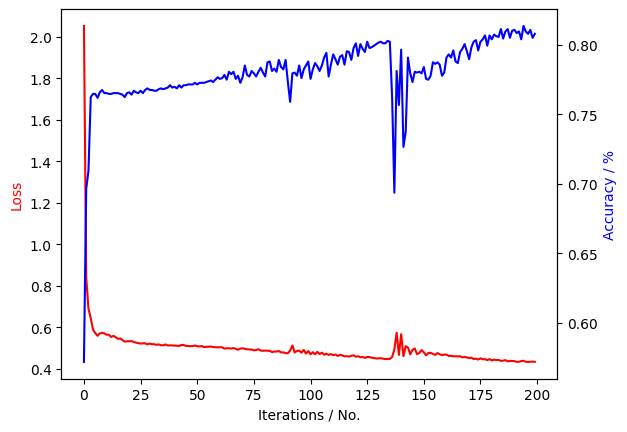

In [14]:
for i in range(len(models)):
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(loss_l[:,i], color = "red")
    ax2.plot(acc_l[:,i], color = "blue")

    ax1.set_xlabel('Iterations / No.')
    ax1.set_ylabel('Loss', color='r')
    ax2.set_ylabel('Accuracy / %', color='b')

In [15]:
enable_wandb = True
if enable_wandb:
    import wandb
    wandb.login()

assert enable_wandb, "W&B not enabled. Please, enable W&B and restart the notebook"

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: Currently logged in as: luxtu. Use `wandb login --relogin` to force relogin


In [20]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(num_feat_dual, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_class_dual)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(17, 16)
  (conv2): GCNConv(16, 3)
)


In [24]:
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def embedding_to_wandb(h, color, key="embedding"):
    num_components = h.shape[-1]
    df = pd.DataFrame(data=h.detach().cpu().numpy(),
                        columns=[f"c_{i}" for i in range(num_components)])
    df["target"] = color.detach().cpu().numpy().astype("str")
    cols = df.columns.tolist()
    df = df[cols[-1:] + cols[:-1]]
    wandb.log({key: df})

def agent_fn():
    wandb.init()
    model = GCN(hidden_channels=wandb.config.hidden_channels)
    wandb.watch(model)

    with torch.no_grad():
      out = model(networkDualXG.x.float(), networkDualXG.edge_index)
      embedding_to_wandb(out, color=networkDualXG.y, key="gcn/embedding/init")

    optimizer = torch.optim.Adam(model.parameters(), lr=wandb.config.lr, weight_decay=wandb.config.weight_decay)
    criterion = torch.nn.CrossEntropyLoss()

    def train():
          model.train()
          optimizer.zero_grad()  # Clear gradients. #
          out = model(networkDualXG.x.float(), networkDualXG.edge_index)  # Perform a single forward pass.
          loss = criterion(out[train_mask].float(), networkDualXG.y[train_mask])  # Compute the loss solely based on the training nodes.
          loss.backward()  # Derive gradients.
          optimizer.step()  # Update parameters based on gradients.
          return loss

    def test():
          model.eval()
          out = model(networkDualXG.x.float(), networkDualXG.edge_index)
          pred = out.argmax(dim=1)  # Use the class with highest probability.
          test_correct = pred[test_mask] == networkDualXG.y[test_mask]  # Check against ground-truth labels.
          test_acc = int(test_correct.sum()) / len(test_mask)  # Derive ratio of correct predictions.
          return test_acc


    for epoch in tqdm(range(1, 101)):
        loss = train()
        wandb.log({"gcn/loss": loss})


    model.eval()

    out = model(networkDualXG.x.float(), networkDualXG.edge_index)
    test_acc = test()
    wandb.summary["gcn/accuracy"] = test_acc
    wandb.log({"gcn/accuracy": test_acc})
    embedding_to_wandb(out, color=networkDualXG.y, key="gcn/embedding/trained")
    wandb.finish()

In [25]:
sweep_config = {
    "name": "gcn-sweep",
    "method": "bayes",
    "metric": {
        "name": "gcn/accuracy",
        "goal": "maximize",
    },
    "parameters": {
        "hidden_channels": {
            "values": [8, 16, 32]
        },
        "weight_decay": {
            "distribution": "normal",
            "mu": 5e-4,
            "sigma": 1e-5,
        },
        "lr": {
            "min": 1e-4,
            "max": 1e-3
        }
    }
}

# Register the Sweep with W&B
sweep_id = wandb.sweep(sweep_config, project="node-classification")

Create sweep with ID: rdzqj7go
Sweep URL: https://wandb.ai/luxtu/node-classification/sweeps/rdzqj7go


In [26]:
# Run the Sweeps agent
wandb.agent(sweep_id, project="node-classification", function=agent_fn, count=50)

wandb: Agent Starting Run: obzx9mx3 with config:
wandb: 	hidden_channels: 32
wandb: 	lr: 0.0008220181910917173
wandb: 	weight_decay: 0.0005095412784633895
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


100%|██████████| 100/100 [00:04<00:00, 21.08it/s]


gcn/accuracy,▁
gcn/loss,█▇▆▆▄▄▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
gcn/accuracy,0.75385
gcn/loss,0.65996


wandb: Agent Starting Run: gct803vo with config:
wandb: 	hidden_channels: 16
wandb: 	lr: 0.0007471545089541348
wandb: 	weight_decay: 0.00048129319536558226
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


100%|██████████| 100/100 [00:03<00:00, 28.85it/s]


gcn/accuracy,▁
gcn/loss,██▇▇▇▇▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
gcn/accuracy,0.46667
gcn/loss,1.4691


wandb: Agent Starting Run: rbw99kgr with config:
wandb: 	hidden_channels: 8
wandb: 	lr: 0.00019037404439711531
wandb: 	weight_decay: 0.0005008501709739677
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


100%|██████████| 100/100 [00:03<00:00, 31.13it/s]


gcn/accuracy,▁
gcn/loss,█▆▇▆▇▆▆▆▆▆▆▅▅▄▄▄▄▅▅▄▄▄▃▄▃▃▃▃▃▃▃▂▂▂▂▂▃▁▁▁
gcn/accuracy,0.58242
gcn/loss,6.17889


wandb: Agent Starting Run: 925d1j26 with config:
wandb: 	hidden_channels: 16
wandb: 	lr: 0.0006004253894812026
wandb: 	weight_decay: 0.0005049534637214581
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


100%|██████████| 100/100 [00:03<00:00, 28.12it/s]


gcn/accuracy,▁
gcn/loss,██▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
gcn/accuracy,0.25201
gcn/loss,1.87308


wandb: Agent Starting Run: 9zv8lkei with config:
wandb: 	hidden_channels: 32
wandb: 	lr: 0.0001939883520610088
wandb: 	weight_decay: 0.0004970769164810502
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


100%|██████████| 100/100 [00:04<00:00, 23.54it/s]


gcn/accuracy,▁
gcn/loss,██▇▇▇▇▇▆▆▆▅▅▅▅▅▄▄▄▃▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
gcn/accuracy,0.74579
gcn/loss,0.92596


wandb: Agent Starting Run: vqpc15wy with config:
wandb: 	hidden_channels: 8
wandb: 	lr: 0.00020157984911307544
wandb: 	weight_decay: 0.0004945459439271409
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


100%|██████████| 100/100 [00:02<00:00, 39.59it/s]


gcn/accuracy,▁
gcn/loss,█▆▇▆▇▆▆▆▆▆▆▅▅▄▄▄▄▅▅▄▄▄▃▄▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁
gcn/accuracy,0.58242
gcn/loss,6.1191


wandb: Agent Starting Run: eqt13hmy with config:
wandb: 	hidden_channels: 32
wandb: 	lr: 0.0007891988010428398
wandb: 	weight_decay: 0.0005079329828748541
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


100%|██████████| 100/100 [00:03<00:00, 26.38it/s]


gcn/accuracy,▁
gcn/loss,█▇▆▆▄▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
gcn/accuracy,0.75385
gcn/loss,0.66261


wandb: Agent Starting Run: 79y9xbed with config:
wandb: 	hidden_channels: 32
wandb: 	lr: 0.00010852046813397864
wandb: 	weight_decay: 0.0004958468234241444


100%|██████████| 100/100 [00:04<00:00, 21.48it/s]


gcn/accuracy,▁
gcn/loss,████▇▇▇▆▇▆▆▆▅▅▆▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▃▂▂▂▂▁▁▁▁
gcn/accuracy,0.7348
gcn/loss,1.16524


wandb: Agent Starting Run: 5w3tq87c with config:
wandb: 	hidden_channels: 32
wandb: 	lr: 0.00017351305021284086
wandb: 	weight_decay: 0.0004901702398122127


100%|██████████| 100/100 [00:03<00:00, 29.28it/s]


gcn/accuracy,▁
gcn/loss,██▇█▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁
gcn/accuracy,0.74066
gcn/loss,0.96848


wandb: Agent Starting Run: 1kggbib8 with config:
wandb: 	hidden_channels: 32
wandb: 	lr: 0.0009819219870800045
wandb: 	weight_decay: 0.0005055347883057734


100%|██████████| 100/100 [00:03<00:00, 25.93it/s]


gcn/accuracy,▁
gcn/loss,█▇▆▅▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
gcn/accuracy,0.75385
gcn/loss,0.64898


wandb: Agent Starting Run: gk83n45j with config:
wandb: 	hidden_channels: 32
wandb: 	lr: 0.0001406700102290371
wandb: 	weight_decay: 0.0004809773619924437


100%|██████████| 100/100 [00:03<00:00, 26.36it/s]


gcn/accuracy,▁
gcn/loss,██▇█▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁
gcn/accuracy,0.73626
gcn/loss,1.05445


wandb: Agent Starting Run: alf0l4k2 with config:
wandb: 	hidden_channels: 32
wandb: 	lr: 0.0009688262815908608
wandb: 	weight_decay: 0.000512043054956957


100%|██████████| 100/100 [00:03<00:00, 27.45it/s]


gcn/accuracy,▁
gcn/loss,█▇▆▅▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
gcn/accuracy,0.75311
gcn/loss,0.64981


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 76bnjd2d with config:
wandb: 	hidden_channels: 32
wandb: 	lr: 0.00012672866224554044
wandb: 	weight_decay: 0.0005076764033471894


100%|██████████| 100/100 [00:03<00:00, 26.42it/s]


gcn/accuracy,▁
gcn/loss,████▇▇▇▆▇▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▂▂▂▂▃▂▂▂▂▁▁▁▁
gcn/accuracy,0.737
gcn/loss,1.09883


wandb: Agent Starting Run: szuzepcw with config:
wandb: 	hidden_channels: 32
wandb: 	lr: 0.00013123535772686302
wandb: 	weight_decay: 0.0005028335523713989


100%|██████████| 100/100 [00:03<00:00, 31.01it/s]


gcn/accuracy,▁
gcn/loss,████▇▇▇▆▇▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▂▂▂▂▃▂▂▂▂▁▁▁▁
gcn/accuracy,0.737
gcn/loss,1.08389


wandb: Agent Starting Run: x4hp6x5u with config:
wandb: 	hidden_channels: 32
wandb: 	lr: 0.0008953693996921958
wandb: 	weight_decay: 0.0005060971230721171


100%|██████████| 100/100 [00:03<00:00, 25.82it/s]


gcn/accuracy,▁
gcn/loss,█▇▆▅▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
gcn/accuracy,0.75385
gcn/loss,0.65465


wandb: Agent Starting Run: y1613vvx with config:
wandb: 	hidden_channels: 32
wandb: 	lr: 0.000103780178831858
wandb: 	weight_decay: 0.0004826311503999217


100%|██████████| 100/100 [00:04<00:00, 23.58it/s]


gcn/accuracy,▁
gcn/loss,████▇▇▇▆▇▆▆▆▅▅▆▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▃▂▂▂▂▁▁▁▁
gcn/accuracy,0.73626
gcn/loss,1.18423


wandb: Agent Starting Run: 465qo02g with config:
wandb: 	hidden_channels: 32
wandb: 	lr: 0.0001227470861047359
wandb: 	weight_decay: 0.0005264057923086717


100%|██████████| 100/100 [00:03<00:00, 27.42it/s]


gcn/accuracy,▁
gcn/loss,████▇▇▇▆▇▆▆▆▅▅▆▅▅▄▄▄▄▄▄▄▃▃▃▂▂▂▂▃▂▂▂▂▁▁▁▁
gcn/accuracy,0.73626
gcn/loss,1.1125


wandb: Agent Starting Run: s2l9g5o7 with config:
wandb: 	hidden_channels: 8
wandb: 	lr: 0.00011951245712329916
wandb: 	weight_decay: 0.0005114071811365155


100%|██████████| 100/100 [00:02<00:00, 39.21it/s]


gcn/accuracy,▁
gcn/loss,█▆▇▅▆▆▆▅▅▆▅▅▅▄▄▄▄▅▅▅▄▅▃▅▃▃▄▃▃▄▃▂▂▂▂▂▃▁▁▁
gcn/accuracy,0.58242
gcn/loss,6.56757


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pkhi7t94 with config:
wandb: 	hidden_channels: 32
wandb: 	lr: 0.0006120693033774266
wandb: 	weight_decay: 0.0005175719846278698


100%|██████████| 100/100 [00:03<00:00, 25.94it/s]


gcn/accuracy,▁
gcn/loss,█▇▆▆▅▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
gcn/accuracy,0.75458
gcn/loss,0.68121


wandb: Agent Starting Run: mfibdfzi with config:
wandb: 	hidden_channels: 32
wandb: 	lr: 0.00037010796819469895
wandb: 	weight_decay: 0.000512025555690817


100%|██████████| 100/100 [00:04<00:00, 23.92it/s]


gcn/accuracy,▁
gcn/loss,██▇▇▆▆▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
gcn/accuracy,0.75018
gcn/loss,0.7514


wandb: Agent Starting Run: kjxzgl15 with config:
wandb: 	hidden_channels: 32
wandb: 	lr: 0.0003002758691207804
wandb: 	weight_decay: 0.0005151630442265222


100%|██████████| 100/100 [00:03<00:00, 25.65it/s]


gcn/accuracy,▁
gcn/loss,██▇▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁
gcn/accuracy,0.75385
gcn/loss,0.79336


wandb: Agent Starting Run: e5ekci0w with config:
wandb: 	hidden_channels: 32
wandb: 	lr: 0.0009942907785336122
wandb: 	weight_decay: 0.0004961508093565711


100%|██████████| 100/100 [00:03<00:00, 25.81it/s]


gcn/accuracy,▁
gcn/loss,█▇▆▅▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
gcn/accuracy,0.75385
gcn/loss,0.64821


wandb: Agent Starting Run: jeku7dwv with config:
wandb: 	hidden_channels: 32
wandb: 	lr: 0.000982582365558366
wandb: 	weight_decay: 0.0005000044569923301


100%|██████████| 100/100 [00:03<00:00, 26.33it/s]


gcn/accuracy,▁
gcn/loss,█▇▆▅▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
gcn/accuracy,0.75385
gcn/loss,0.64895


wandb: Agent Starting Run: a35fndue with config:
wandb: 	hidden_channels: 32
wandb: 	lr: 0.0008286460240814292
wandb: 	weight_decay: 0.0005273230704690487


100%|██████████| 100/100 [00:03<00:00, 25.33it/s]


gcn/accuracy,▁
gcn/loss,█▇▆▆▄▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
gcn/accuracy,0.75385
gcn/loss,0.65945


wandb: Agent Starting Run: x1e4728a with config:
wandb: 	hidden_channels: 32
wandb: 	lr: 0.00029486807553957855
wandb: 	weight_decay: 0.0005039348158430022


100%|██████████| 100/100 [00:03<00:00, 27.65it/s]


gcn/accuracy,▁
gcn/loss,██▇▇▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁
gcn/accuracy,0.75458
gcn/loss,0.79762


wandb: Agent Starting Run: b198554t with config:
wandb: 	hidden_channels: 8
wandb: 	lr: 0.00010285629317857155
wandb: 	weight_decay: 0.0004854221178907864


100%|██████████| 100/100 [00:02<00:00, 35.17it/s]


gcn/accuracy,▁
gcn/loss,█▅▇▅▆▆▆▅▅▆▅▅▅▄▄▄▄▅▅▅▄▅▃▅▃▃▄▃▃▄▃▂▂▂▂▂▃▁▁▂
gcn/accuracy,0.58242
gcn/loss,6.66162


wandb: Agent Starting Run: ouosjmdn with config:
wandb: 	hidden_channels: 32
wandb: 	lr: 0.00027967167275271806
wandb: 	weight_decay: 0.000498756167419122


100%|██████████| 100/100 [00:04<00:00, 22.70it/s]


gcn/accuracy,▁
gcn/loss,██▇▇▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▃▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁
gcn/accuracy,0.75385
gcn/loss,0.81064


wandb: Agent Starting Run: v8sxdvzg with config:
wandb: 	hidden_channels: 32
wandb: 	lr: 0.0009674159427705092
wandb: 	weight_decay: 0.000492395213676577


100%|██████████| 100/100 [00:04<00:00, 21.36it/s]


gcn/accuracy,▁
gcn/loss,█▇▆▅▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
gcn/accuracy,0.75311
gcn/loss,0.6499


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: m96qp1yu with config:
wandb: 	hidden_channels: 32
wandb: 	lr: 0.0006887767233119628
wandb: 	weight_decay: 0.0005136544660344904


100%|██████████| 100/100 [00:04<00:00, 23.72it/s]


gcn/accuracy,▁
gcn/loss,█▇▆▆▅▅▄▄▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
gcn/accuracy,0.75458
gcn/loss,0.67198


wandb: Agent Starting Run: kflcghwg with config:
wandb: 	hidden_channels: 32
wandb: 	lr: 0.0005276008946416723
wandb: 	weight_decay: 0.0004960594961975298


100%|██████████| 100/100 [00:04<00:00, 24.88it/s]


gcn/accuracy,▁
gcn/loss,██▇▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
gcn/accuracy,0.75458
gcn/loss,0.69516


wandb: Agent Starting Run: ipobohqi with config:
wandb: 	hidden_channels: 32
wandb: 	lr: 0.0003598979846343875
wandb: 	weight_decay: 0.0005265420239057137


100%|██████████| 100/100 [00:04<00:00, 23.65it/s]


gcn/accuracy,▁
gcn/loss,██▇▇▆▆▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁
gcn/accuracy,0.75018
gcn/loss,0.7563


wandb: Agent Starting Run: 3vq2jjg8 with config:
wandb: 	hidden_channels: 32
wandb: 	lr: 0.0005429853872294545
wandb: 	weight_decay: 0.0004920393368669096


100%|██████████| 100/100 [00:03<00:00, 26.68it/s]


gcn/accuracy,▁
gcn/loss,██▇▆▅▅▅▄▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
gcn/accuracy,0.75531
gcn/loss,0.69226


wandb: Agent Starting Run: euwc8k8k with config:
wandb: 	hidden_channels: 32
wandb: 	lr: 0.0004357828212669129
wandb: 	weight_decay: 0.0004968207549979133


100%|██████████| 100/100 [00:03<00:00, 27.96it/s]


gcn/accuracy,▁
gcn/loss,██▇▇▆▆▅▅▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
gcn/accuracy,0.75385
gcn/loss,0.7184


wandb: Agent Starting Run: awb96l2a with config:
wandb: 	hidden_channels: 32
wandb: 	lr: 0.0006464168334688224
wandb: 	weight_decay: 0.0004951963458047685


100%|██████████| 100/100 [00:03<00:00, 27.78it/s]


gcn/accuracy,▁
gcn/loss,█▇▆▆▅▅▄▄▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
gcn/accuracy,0.75531
gcn/loss,0.67675


wandb: Agent Starting Run: qaukgpmn with config:
wandb: 	hidden_channels: 32
wandb: 	lr: 0.00036147421344894664
wandb: 	weight_decay: 0.000479982483976316


100%|██████████| 100/100 [00:03<00:00, 27.17it/s]


gcn/accuracy,▁
gcn/loss,██▇▇▆▆▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁
gcn/accuracy,0.75018
gcn/loss,0.75551


wandb: Agent Starting Run: 5rtg9aen with config:
wandb: 	hidden_channels: 32
wandb: 	lr: 0.00033578854536394563
wandb: 	weight_decay: 0.0004969378494130886


100%|██████████| 100/100 [00:03<00:00, 26.15it/s]


gcn/accuracy,▁
gcn/loss,██▇▇▆▆▆▅▅▅▄▄▄▄▄▃▃▃▂▃▂▂▂▂▂▂▂▂▁▂▁▂▂▁▁▁▁▁▁▁
gcn/accuracy,0.75018
gcn/loss,0.76933


wandb: Agent Starting Run: abp541q5 with config:
wandb: 	hidden_channels: 32
wandb: 	lr: 0.0008871105966050616
wandb: 	weight_decay: 0.0005004577990167542


100%|██████████| 100/100 [00:03<00:00, 29.70it/s]


gcn/accuracy,▁
gcn/loss,█▇▆▅▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
gcn/accuracy,0.75385
gcn/loss,0.65521


wandb: Agent Starting Run: op1y6etr with config:
wandb: 	hidden_channels: 32
wandb: 	lr: 0.0003283276649565674
wandb: 	weight_decay: 0.0004927424786351838


100%|██████████| 100/100 [00:04<00:00, 23.95it/s]


gcn/accuracy,▁
gcn/loss,██▇▇▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▂▂▁▁▁▁▁▁▁
gcn/accuracy,0.75092
gcn/loss,0.77387


wandb: Agent Starting Run: c89m4o9p with config:
wandb: 	hidden_channels: 32
wandb: 	lr: 0.0007731447495505269
wandb: 	weight_decay: 0.0004897315811752498


100%|██████████| 100/100 [00:04<00:00, 23.87it/s]


gcn/accuracy,▁
gcn/loss,█▇▆▆▅▄▄▃▃▃▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
gcn/accuracy,0.75531
gcn/loss,0.66394


wandb: Agent Starting Run: huaerzpx with config:
wandb: 	hidden_channels: 32
wandb: 	lr: 0.0008997915957409576
wandb: 	weight_decay: 0.0004972512303840272


100%|██████████| 100/100 [00:03<00:00, 25.20it/s]


gcn/accuracy,▁
gcn/loss,█▇▆▅▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
gcn/accuracy,0.75385
gcn/loss,0.65434


wandb: Agent Starting Run: eyqfwd9f with config:
wandb: 	hidden_channels: 32
wandb: 	lr: 0.0003502032327833951
wandb: 	weight_decay: 0.0004886174451373189


100%|██████████| 100/100 [00:04<00:00, 22.67it/s]


gcn/accuracy,▁
gcn/loss,██▇▇▆▆▆▅▅▅▄▄▄▃▄▃▃▃▂▃▂▂▂▂▂▂▂▂▁▂▁▂▂▁▁▁▁▁▁▁
gcn/accuracy,0.75018
gcn/loss,0.76126


wandb: Agent Starting Run: iai951zc with config:
wandb: 	hidden_channels: 32
wandb: 	lr: 0.0006054303723522903
wandb: 	weight_decay: 0.0004877296887444949


100%|██████████| 100/100 [00:03<00:00, 26.68it/s]


gcn/accuracy,▁
gcn/loss,█▇▆▆▅▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
gcn/accuracy,0.75458
gcn/loss,0.68214


wandb: Agent Starting Run: ou2uwvok with config:
wandb: 	hidden_channels: 32
wandb: 	lr: 0.0008203236918623475
wandb: 	weight_decay: 0.0004935537283363351


100%|██████████| 100/100 [00:03<00:00, 28.34it/s]


gcn/accuracy,▁
gcn/loss,█▇▆▆▄▄▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
gcn/accuracy,0.75385
gcn/loss,0.66008


wandb: Agent Starting Run: g4pp034k with config:
wandb: 	hidden_channels: 32
wandb: 	lr: 0.0009971113462056886
wandb: 	weight_decay: 0.0005032322807342068


100%|██████████| 100/100 [00:04<00:00, 22.91it/s]


gcn/accuracy,▁
gcn/loss,█▇▆▅▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
gcn/accuracy,0.75385
gcn/loss,0.64803


wandb: Agent Starting Run: fu9vez9t with config:
wandb: 	hidden_channels: 32
wandb: 	lr: 0.0005128424628896482
wandb: 	weight_decay: 0.0004988223638252293


100%|██████████| 100/100 [00:04<00:00, 24.10it/s]


gcn/accuracy,▁
gcn/loss,██▇▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
gcn/accuracy,0.75385
gcn/loss,0.69809


wandb: Agent Starting Run: tgvgndbr with config:
wandb: 	hidden_channels: 32
wandb: 	lr: 0.0007007025183851342
wandb: 	weight_decay: 0.0004995623087058508


100%|██████████| 100/100 [00:04<00:00, 24.54it/s]


gcn/accuracy,▁
gcn/loss,█▇▆▆▅▅▄▃▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
gcn/accuracy,0.75385
gcn/loss,0.67075


wandb: Agent Starting Run: pqil27p5 with config:
wandb: 	hidden_channels: 32
wandb: 	lr: 0.0008706562284272138
wandb: 	weight_decay: 0.00048166646593005615


100%|██████████| 100/100 [00:03<00:00, 28.88it/s]


gcn/accuracy,▁
gcn/loss,█▇▆▅▄▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
gcn/accuracy,0.75385
gcn/loss,0.65637


wandb: Agent Starting Run: sii1vkk3 with config:
wandb: 	hidden_channels: 32
wandb: 	lr: 0.0006339522517852943
wandb: 	weight_decay: 0.0004769734359054844


100%|██████████| 100/100 [00:03<00:00, 29.32it/s]


gcn/accuracy,▁
gcn/loss,█▇▆▆▅▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
gcn/accuracy,0.75531
gcn/loss,0.67833


wandb: Agent Starting Run: idwoprne with config:
wandb: 	hidden_channels: 32
wandb: 	lr: 0.0005368982263632959
wandb: 	weight_decay: 0.0004901949384882092


100%|██████████| 100/100 [00:03<00:00, 30.16it/s]


gcn/accuracy,▁
gcn/loss,██▇▆▅▅▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
gcn/accuracy,0.75531
gcn/loss,0.69335


wandb: Agent Starting Run: eq3325hr with config:
wandb: 	hidden_channels: 32
wandb: 	lr: 0.0004971710698928007
wandb: 	weight_decay: 0.00048584144517065304


100%|██████████| 100/100 [00:04<00:00, 21.41it/s]


gcn/accuracy,▁
gcn/loss,██▇▇▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
gcn/accuracy,0.75458
gcn/loss,0.70156
